In [1]:
import qiskit
qiskit.__version__

'1.3.1'

In [31]:
from qiskit import *
from qiskit.visualization import *
from qiskit.quantum_info import Operator
from qiskit_aer import AerSimulator
import numpy as np
import matplotlib.pyplot as plt

# Two-spin Heisenberg model

Example 3.1: Two-qubit Heisenberg model.} Consider a two-qubit isotropic Heisenberg model described by the Hamiltonian  
\begin{align}
    \hat{H} = \prod_j \sigma^j\otimes \sigma^j = X \otimes X + Y \otimes Y + Z \otimes Z,
\end{align}
and an initial state given by  
\begin{align}
    |\psi(0)\rangle = \frac{1}{\sqrt{2}} |0\rangle \big(|0\rangle + |1\rangle\big).
\end{align}
The observables of interest are the magnetizations of the two spins, defined as  
\begin{align}
    s_z^{(i)} \equiv \frac{1}{2} Z^{(i)},
\end{align}
where \( Z^{(i)} \) represents the \( Z \)-gate acting on the \( i^{\text{th}} \) qubit.

\begin{align}
\hat{U}(t) = e^{-it X\otimes X} e^{-it Y\otimes Y} e^{-it Z\otimes Z} = H e^{-it Z\otimes Z} H SH e^{-it Z\otimes Z} H S^\dagger  e^{-it Z\otimes Z}.
\end{align}


\begin{align}
    \hat{U}(t)&=e^{-i t \hat{H}}= \prod_j e^{-i t \sigma^j\otimes \sigma^j}
    = \prod_j(\cos t - i \sin t \, \sigma^j \otimes \sigma^j)\notag\\
    &= e^{i t}\cos^2 t - i \sin t - \frac{i}{2} e^{it}\sin(2t)\prod_j \sigma^j\otimes \sigma^j.
\end{align}

## Circuit

In [2]:
def U2Exact(t):
    X = [[0.0, 1.0], [1.0, 0.0]]
    Y = [[0.0, -1.0j], [1.0j, 0.0]]
    Z = [[1.0, 0.0], [0.0, -1.0]]
    ss = np.kron(X, X) + np.kron(Y, Y) + np.kron(Z, Z)
    return ( np.exp(1.0j*t)*np.cos(t)**2 - 1.0j*np.sin(t))*np.identity(4) -0.5j*np.exp(1.0j*t)*np.sin(2*t)*ss

In [3]:
def UZZ(ut, t):    
    ut.cx(1, 0)
    ut.rz(2*t, 0)
    ut.cx(1, 0)
    return ut


In [4]:
def U2(t):
    """
    """
    ut = QuantumCircuit(2, name = '$U_2$')

    UZZ(ut, t)
    ut.barrier()

    # YY
    ut.s(0)
    ut.z(0)
    ut.h(0)
    ut.s(1)
    ut.z(1)
    ut.h(1)

    UZZ(ut, t)

    ut.h(0)
    ut.h(1)
    ut.s(0)
    ut.s(1)
    ut.barrier()
    
    # XX
    ut.h(0)
    ut.h(1)
    UZZ(ut, t)
    ut.h(0)
    ut.h(1)

    return ut

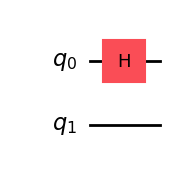

In [7]:
# 1. the initial state
psi = QuantumCircuit(2)
psi.h(0)
psi.draw('mpl')

In [8]:
# 2. the evolution operator
U = U2(1)

In [9]:
np.abs(Operator(U).data - U2Exact(1))<1e-15

array([[ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True]])

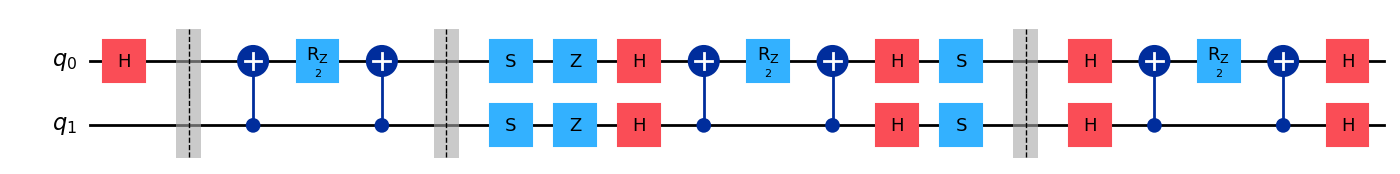

In [9]:
psi.barrier()
psi &= U
psi.draw('mpl')

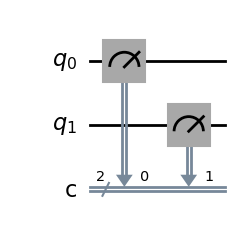

In [10]:
# 3. Measurement
qbits, cbits = QuantumRegister(2, 'q'), ClassicalRegister(2, 'c')

mea = QuantumCircuit(qbits, cbits)

mea.measure(qbits, cbits)

mea.draw('mpl')

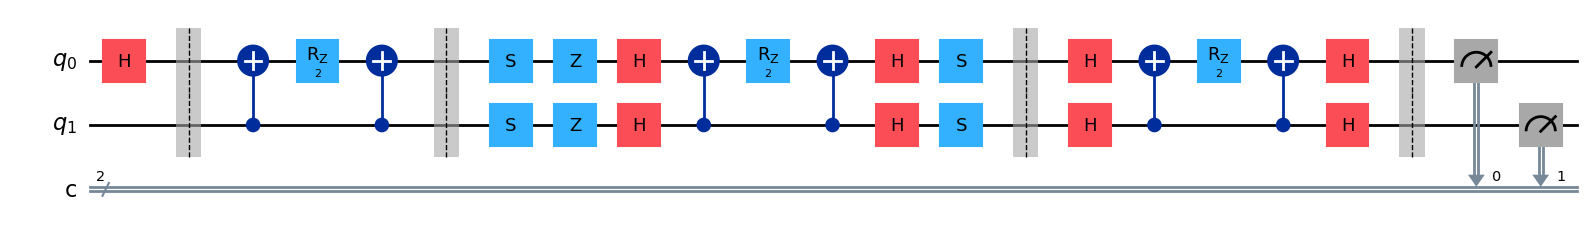

In [11]:
psi.barrier()
psi &= mea
heisenberg2 = psi.draw('mpl')
heisenberg2

In [61]:
heisenberg2.savefig('circuit_Heisenberg2.pdf')

## Results

In [12]:
from qiskit import *
from qiskit.visualization import *
from qiskit.quantum_info import Operator
import numpy as np
from qiskit.providers.basic_provider import BasicSimulator

In [14]:
def run(t, sshots):
    # Circuit
    # 1. the initial state
    psi = QuantumCircuit(2)
    psi.h(0)
    psi.barrier()

    psi &= U2(t)

    # 3. Measurement
    qbits, cbits = QuantumRegister(2, 'q'), ClassicalRegister(2, 'c')

    mea = QuantumCircuit(qbits, cbits)

    mea.measure(qbits, cbits)

    psi.barrier()
    psi &= mea

    #print('t = {t}')
    #display(psi.draw('mpl'))

    # run
    backend = BasicSimulator()
    job_simulator = backend.run(transpile(psi), shots=sshots)
    result_simulator = job_simulator.result()
    return result_simulator.get_counts()    

In [15]:
ss = 5120

res = [[ti, run(ti, ss)] for ti in np.linspace(0.0, np.pi, 20)]

In [16]:
s0=np.array([ [c[0], np.sum([0.5*(-1)**float(k[1])*c[1][k]/ss for k in c[1].keys()]) ] for c in res])
s1=np.array([ [c[0], np.sum([0.5*(-1)**float(k[0])*c[1][k]/ss for k in c[1].keys()]) ] for c in res])

In [17]:
ts = np.linspace(0, np.pi, 100)

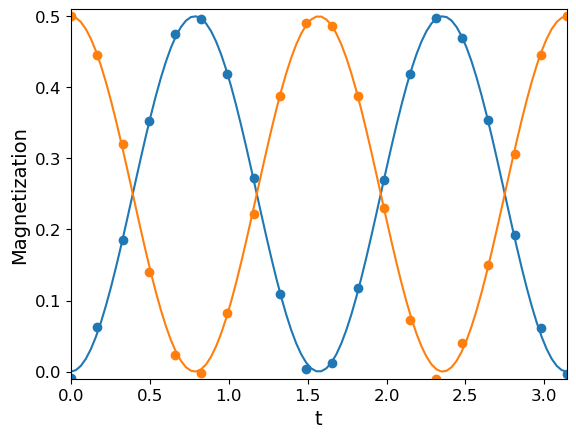

In [18]:
plt.scatter(s0[:, 0], s0[:, 1])
plt.scatter(s1[:, 0], s1[:, 1])
plt.plot(ts, 0.5*np.sin(2.0*ts)**2)
plt.plot(ts, 0.5*np.cos(2.0*ts)**2)

plt.xlim([0, np.pi])
plt.ylim([-0.01, 0.51])
#plt.grid()
plt.xlabel("t", fontsize=14)
plt.ylabel("Magnetization", fontsize=14)

plt.tick_params(axis='both', which='major', labelsize=12)

plt.savefig('results_Heisenberg2.pdf')

# Three-spin Heisenberg model

https://arxiv.org/pdf/1907.03505

## Direct exponentiation

In [19]:
def H3(B):
    X = np.array([[0, 1.0], [1.0, 0]])
    Y = np.array([[0, -1.0j], [1.0j, 0]])
    Z = np.array([[1.0, 0.0], [0.0, -1.0]])
    I = np.identity(2)
    H2 = np.kron(X, X) + np.kron(Y, Y) + np.kron(Z, Z)
    H0 = np.kron(I, H2) + np.kron(H2, I)
    Hg = np.kron(np.kron(Z, I), I) + np.kron(np.kron(I, Z), I) + np.kron(np.kron(I, I), Z)

    return H0 + 0.5*B*Hg

In [20]:
def psi0(q2, q1, q0):
    """
    qi in binary
    """
    comp_basis = np.array([[1.0,0],[0, 1.0]])
    return np.kron(comp_basis[:, q2], np.kron(comp_basis[:, q1], comp_basis[:, q0]))

In [21]:
from scipy.linalg import expm
def U3(t, B):
    return expm(-1.0j*t*H3(B))

In [22]:
ts = np.linspace(0, np.pi, 100)

In [23]:
ut = [U3(t, 20) for t in ts]

In [24]:
p0 = psi0(1, 0, 0)

In [25]:
pts = [u@p0 for u in ut]

In [26]:
p0pts = np.array([p0@pt for pt in pts])

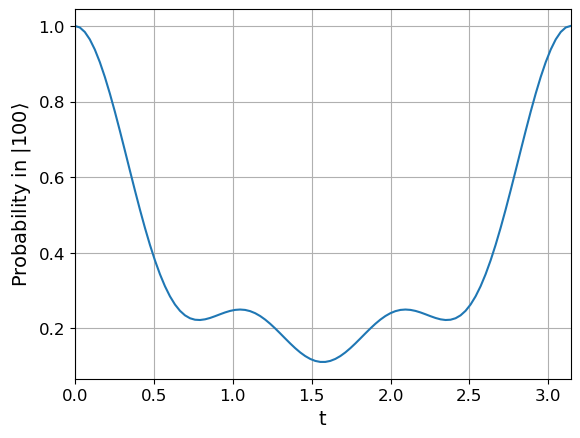

In [27]:
plt.plot(ts, np.abs(p0pts)**2)
plt.xlim([0, np.pi])
plt.grid()
plt.xlabel("t", fontsize=14)
plt.ylabel(r"Probability in $|100\rangle$", fontsize=14)

plt.tick_params(axis='both', which='major', labelsize=12)

## Circuit implementation|

In [28]:
t = 1.0
nt = 5
B = 20.0
Uab = U2(t/5)

In [29]:
U2_inst = Uab.to_instruction()

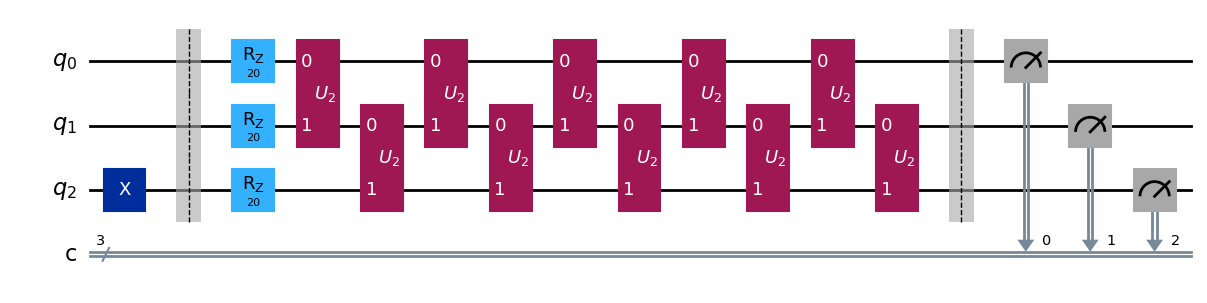

In [30]:
# initial state
qc = QuantumCircuit(3, 3)
qc.x(-1)

qc.barrier()

# circuit

for i in range(len(qc.qubits)):
    qc.rz(20*t, i)

for i in range(nt):
    qc.append(U2_inst, [0, 1])
    qc.append(U2_inst, [1, 2])

qc.barrier()

# measurement
qc.measure(qc.qubits, qc.clbits)

h3 = qc.draw('mpl')
h3

In [168]:
h3.savefig('circuit_Heisenberg3.pdf')

In [34]:
ss = 5120
backend = AerSimulator()
job_simulator = backend.run(transpile(qc, backend), shots=ss)
result_simulator = job_simulator.result()
result_simulator.get_counts()    

{'100': 1134, '001': 3589, '010': 397}

In [11]:
1051/ss

0.2052734375

In [39]:
def run(t, dt, sshots):
    nt = int(np.ceil(t/dt))
    #print(nt*dt, t)
    B = 20.0

    Uab = U2(dt)
    U2_inst = Uab.to_instruction()
    # Circuit
    # initial state
    qc = QuantumCircuit(3, 3)
    qc.x(-1)

    qc.barrier()

    # circuit

    for i in range(len(qc.qubits)):
        qc.rz(20*t, i)

    for i in range(nt):
        qc.append(U2_inst, [0, 1])
        qc.append(U2_inst, [1, 2])

    qc.barrier()

    # measurement
    qc.measure(qc.qubits, qc.clbits)

    #qc.draw('mpl')
    #print('t = {t}')
    #display(qc.draw('mpl'))

    # run
    backend = BasicSimulator()
    job_simulator = backend.run(transpile(qc, backend), shots=sshots)
    result_simulator = job_simulator.result()
    counts = result_simulator.get_counts()
    #print("t = {}: counts = {}".format(t, counts))
    p = 0.0
    if '100' in counts.keys():
        p = counts['100']/sshots
    return p

In [40]:
simuref = np.array([[t, run(t, 0.01*np.pi, 15120)] for t in np.linspace(0.0, np.pi, 20)])

In [41]:
simu = np.array([[t, run(t, 0.05*np.pi, 5120)] for t in np.linspace(0.0, np.pi, 20)])

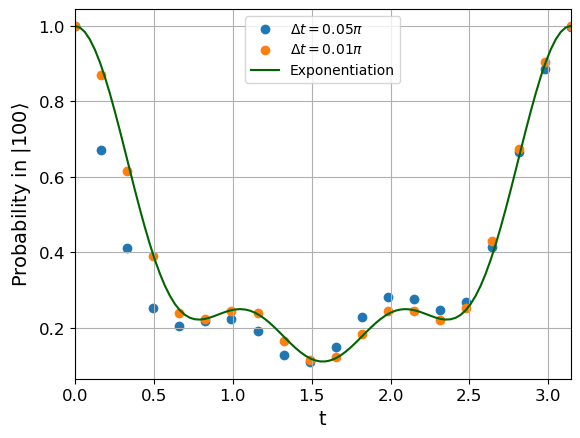

In [44]:
plt.scatter(simu[:, 0], simu[:, 1], label=r'$\Delta t = 0.05\pi$')
plt.scatter(simuref[:, 0], simuref[:, 1], label=r'$\Delta t = 0.01\pi$')
plt.plot(ts, np.abs(p0pts)**2, 'darkgreen', label='Exponentiation')
plt.xlim([0, np.pi])
plt.grid()
plt.xlabel("t", fontsize=14)
plt.ylabel(r"Probability in $|100\rangle$", fontsize=14)
plt.legend(loc='upper center')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.savefig('results_Heisenberg3.pdf')